<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/timeseries/probabilistic_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates various time series forecasting models, including:
* Traditional methods like ARIMA, SARIMAX, and TBATS
* Machine learning and deep learning approaches like Quantile Regression (Gradient Boosting Regressor), Bayesian Modeling (PyMC3), and MC Dropout (PyTorch)

The goal is to compare their performance in forecasting daily sales data.

In [6]:
!pip install numpy==1.26.4
!pip install tbats mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import TBATS
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from mapie.regression import MapieRegressor
import pymc as pm
import torch
import torch.nn as nn
import arviz as az
import matplotlib.pyplot as plt

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("beatafaron/fmcg-daily-sales-data-to-2022-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fmcg-daily-sales-data-to-2022-2024' dataset.
Path to dataset files: /kaggle/input/fmcg-daily-sales-data-to-2022-2024


In [3]:
!ls -lart  /kaggle/input/fmcg-daily-sales-data-to-2022-2024

total 22624
-rw-r--r-- 1 1000 1000   354378 Sep 22 04:22 df_weekly_MI-006_enriched.csv
-rw-r--r-- 1 1000 1000    11764 Sep 22 04:22 batch_MI-006_2025-01-13.parquet
-rw-r--r-- 1 1000 1000    11723 Sep 22 04:22 batch_MI-006_2025-01-20.parquet
-rw-r--r-- 1 1000 1000    11332 Sep 22 04:22 batch_MI-006_2025-01-06.parquet
-rw-r--r-- 1 1000 1000    11766 Sep 22 04:22 batch_MI-006_2025-01-27.parquet
-rw-r--r-- 1 1000 1000  5005351 Sep 22 04:22 weekly_df_final_for_modeling.csv
-rw-r--r-- 1 1000 1000 17747435 Sep 22 04:22 FMCG_2022_2024.csv
drwxr-sr-x 2 1000 1000        0 Sep 22 04:24 .
drwxr-xr-x 3 root root     4096 Sep 22 04:29 ..


In [4]:
!ls {path}
path += "/FMCG_2022_2024.csv"

batch_MI-006_2025-01-06.parquet  df_weekly_MI-006_enriched.csv
batch_MI-006_2025-01-13.parquet  FMCG_2022_2024.csv
batch_MI-006_2025-01-20.parquet  weekly_df_final_for_modeling.csv
batch_MI-006_2025-01-27.parquet


In [5]:
data_df = pd.read_csv(path, parse_dates=['date'], index_col='date')
data_df.head()

,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
date,,,,,,,,,,,,,
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


In [6]:
# Forecast per SKU + Region
group_cols = ["sku", "region"]

daily_sales = (
    data_df.groupby(group_cols + [pd.Grouper(freq="D")])["units_sold"]
      .sum()
      .reset_index()
)

# Pivot so each (sku, region) becomes a column
sales_pivot = daily_sales.pivot(index="date", columns=group_cols, values="units_sold").fillna(0)
sales_pivot.head()


sku            JU-021                       MI-002                    \
region     PL-Central PL-North PL-South PL-Central PL-North PL-South   
date                                                                   
2022-01-21        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-22        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-23        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-24        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-25        0.0      0.0      0.0        0.0      0.0      0.0   

sku            MI-006                       MI-008  ...   YO-018     YO-020  \
region     PL-Central PL-North PL-South PL-Central  ... PL-South PL-Central   
date                                                ...                       
2022-01-21       16.0     19.0     50.0        0.0  ...      0.0        0.0   
2022-01-22       63.0     17.0     39.0        0.0  ...      0.0        0.0   
2022-01-23       35.0     30.0     57.0        0.0  ...      0.0        0.0   
2022-01-24       23.0     31.0     22.0        0.0  ...      0.0        0.0   
2022-01-25       35.0     23.0     18.0        0.0  ...      0.0        0.0   

sku                              YO-024                       YO-029           \
region     PL-North PL-South PL-Central PL-North PL-South PL-Central PL-North   
date                                                                            
2022-01-21      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-22      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-23      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-24      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-25      0.0      0.0        0.0      0.0      0.0        0.0      0.0   

sku                  
region     PL-South  
date                 
2022-01-21      0.0  
2022-01-22      0.0  
2022-01-23      0.0  
2022-01-24      0.0  
2022-01-25      0.0  

[5 rows x 90 columns]

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import TBATS
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from mapie.regression import MapieRegressor
import pymc as pm
import torch
import torch.nn as nn

# Pick one SKU-region
top_pair = data_df.groupby(['sku','region'])['units_sold'].sum().idxmax()
sub = data_df[(data_df['sku']==top_pair[0]) & (data_df['region']==top_pair[1])]

# Aggregate daily
series = sub['units_sold'].resample('D').sum().astype(float)
dates_future = pd.date_range(series.index[-1], periods=31, freq='D')[1:]


#### ARMA

In [8]:
arma_model = ARIMA(series, order=(2,0,2)).fit()
arma_forecast = arma_model.forecast(30)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Sarimax

In [9]:
sarimax_model = SARIMAX(series, order=(2,0,2), seasonal_order=(1,0,1,7),
                        enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
sarimax_forecast = sarimax_model.get_forecast(30).predicted_mean

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


#### Tbats

In [10]:
tbats_estimator = TBATS(seasonal_periods=[7])
tbats_model = tbats_estimator.fit(series)
tbats_forecast = tbats_model.forecast(30)

#### Quantile regression (GBR)

In [11]:
df_ml = series.to_frame('y')
df_ml['lag_1'] = df_ml['y'].shift(1)
df_ml['lag_7'] = df_ml['y'].shift(7)
df_ml = df_ml.dropna()
X = df_ml[['lag_1','lag_7']]
y = df_ml['y']

quantiles = [0.1,0.5,0.9]
quantile_preds = {}
for q in quantiles:
    model = GradientBoostingRegressor(loss='quantile', alpha=q)
    model.fit(X, y)
    lag_1, lag_7 = X.iloc[-1]
    preds = []
    for _ in range(30):
        x_pred = np.array([[lag_1, lag_7]])
        y_pred = model.predict(x_pred)[0]
        preds.append(y_pred)
        lag_7, lag_1 = lag_1, y_pred
    quantile_preds[q] = preds


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493:

#### Ensemble of models

In [12]:
ensemble_forecast = np.vstack([arma_forecast.values, sarimax_forecast.values, tbats_forecast])
ensemble_mean = ensemble_forecast.mean(axis=0)
ensemble_std = ensemble_forecast.std(axis=0)

#### Bayesian model

In [18]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1, shape=2)
    sigma = pm.HalfNormal('sigma', 1)
    mu = alpha + pm.math.dot(X.values, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y.values)
    trace = pm.sample(500, tune=500, progressbar=False, cores=1)

# Posterior predictive samples
with model:
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=['y_obs'], progressbar=False)

# Correctly extract posterior predictive samples
posterior_array = posterior_pred.posterior_predictive['y_obs'].values  # shape: (chains, draws, n_obs)
posterior_array = posterior_array.reshape(-1, posterior_array.shape[-1])  # flatten chains & draws
bayes_mean = posterior_array.mean(axis=0)[-30:]
bayes_std = posterior_array.std(axis=0)[-30:]


#### MC Dropout

In [19]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,16)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Train simplified for demo
model_nn = FCNet()
model_nn.train()
X_tensor = torch.tensor(X.values).float()
y_tensor = torch.tensor(y.values).float().unsqueeze(1)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
for _ in range(200):
    optimizer.zero_grad()
    y_pred = model_nn(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

# MC dropout
model_nn.train()
preds = []
lag_1, lag_7 = X.values[-1]
for _ in range(30):
    x_pred = torch.tensor([[lag_1, lag_7]]).float()
    y_pred = np.array([model_nn(x_pred).detach().numpy()[0][0] for _ in range(100)])
    preds.append(y_pred.mean())
    lag_7, lag_1 = lag_1, preds[-1]
mc_mean = np.array(preds)
mc_std = np.std(preds, axis=0)

#### Conformal prediction

In [20]:
rf = RandomForestRegressor()
mapie = MapieRegressor(rf, method='plus')
mapie.fit(X, y)
y_pred, y_pis = mapie.predict(X, alpha=0.1)
conformal_lower = y_pis[-30:,0]
conformal_upper = y_pis[-30:,1]

In [24]:
forecast_df = pd.DataFrame({
    'date': dates_future,
    'sku': top_pair[0],
    'region': top_pair[1],
    'ARMA': arma_forecast.values.ravel(),
    'SARIMAX': sarimax_forecast.values.ravel(),
    'Bayesian_mean': bayes_mean.ravel(),
    'Bayesian_std': bayes_std.ravel(),
    'Quantile_10': quantile_preds[0.1],
    'Quantile_50': quantile_preds[0.5],
    'Quantile_90': quantile_preds[0.9],
})

forecast_df.head()

,date,sku,region,ARMA,SARIMAX,Bayesian_mean,Bayesian_std,Quantile_10,Quantile_50,Quantile_90
0,2025-01-01,YO-029,PL-North,37.793208,37.978597,50.872021,22.673032,22.953108,44.020396,76.788451
1,2025-01-02,YO-029,PL-North,38.683497,37.896438,57.151289,22.581620,23.110636,43.534523,100.104452
2,2025-01-03,YO-029,PL-North,38.306112,39.234092,52.340092,22.772979,23.748858,45.048821,108.223685
3,2025-01-04,YO-029,PL-North,38.878598,34.472774,54.695751,23.109186,23.748858,45.378740,109.398759
4,2025-01-05,YO-029,PL-North,38.734455,37.726470,44.911066,23.272610,23.110636,46.566730,109.398759


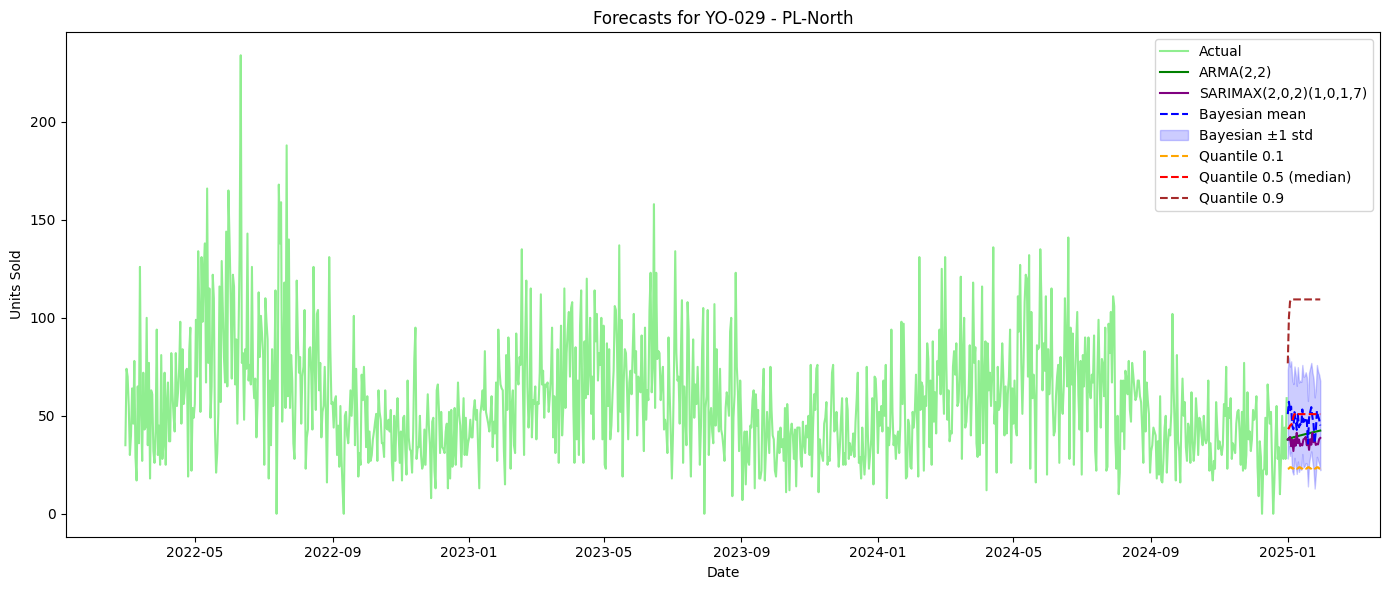

In [30]:
plt.figure(figsize=(14,6))

# Original trend
plt.plot(series.index, series.values, label='Actual', color='lightgreen')

# Forecasts from forecast_df
plt.plot(forecast_df['date'], forecast_df['ARMA'], label='ARMA(2,2)', color='green', linestyle='-')
plt.plot(forecast_df['date'], forecast_df['SARIMAX'], label='SARIMAX(2,0,2)(1,0,1,7)', color='purple', linestyle='-')
plt.plot(forecast_df['date'], forecast_df['Bayesian_mean'], label='Bayesian mean', color='blue', linestyle='--')
plt.fill_between(forecast_df['date'],
                 forecast_df['Bayesian_mean'] - forecast_df['Bayesian_std'],
                 forecast_df['Bayesian_mean'] + forecast_df['Bayesian_std'],
                 color='blue', alpha=0.2, label='Bayesian ±1 std')
plt.plot(forecast_df['date'], forecast_df['Quantile_10'], label='Quantile 0.1', color='orange', linestyle='--')
plt.plot(forecast_df['date'], forecast_df['Quantile_50'], label='Quantile 0.5 (median)', color='red', linestyle='--')
plt.plot(forecast_df['date'], forecast_df['Quantile_90'], label='Quantile 0.9', color='brown', linestyle='--')

plt.title(f"Forecasts for {top_pair[0]} - {top_pair[1]}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

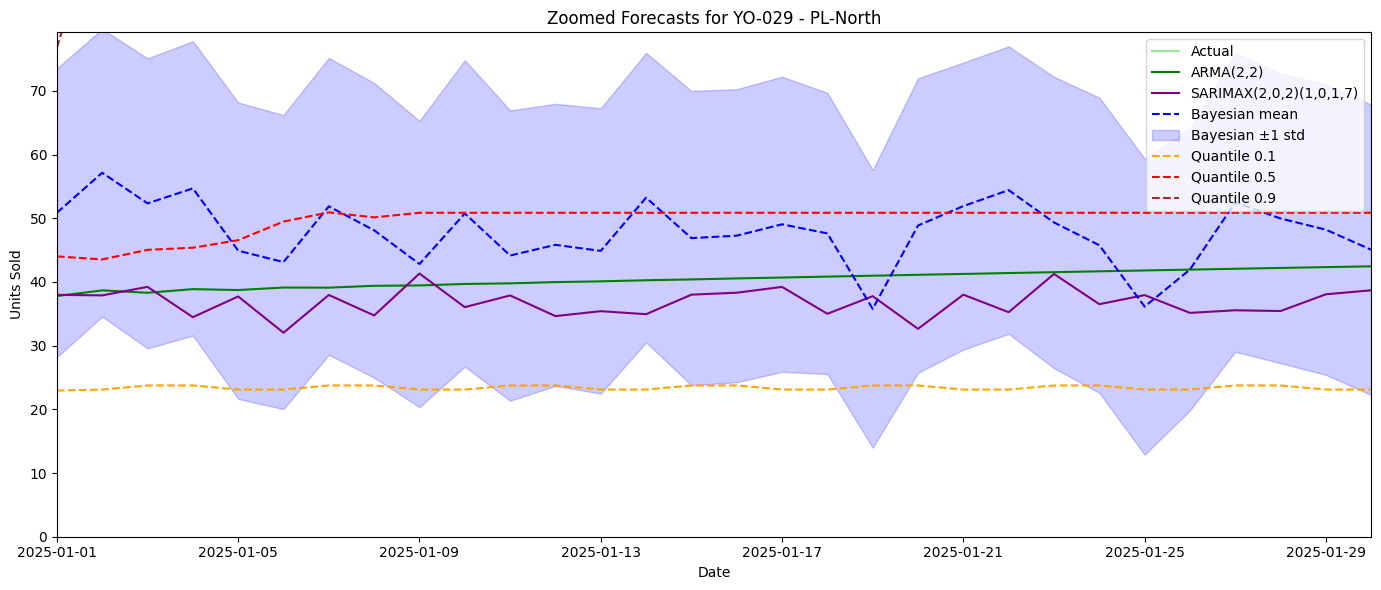

In [32]:
plt.figure(figsize=(14,6))

# Original trend
plt.plot(series.index, series.values, label='Actual', color='lightgreen')

# Forecasts
plt.plot(forecast_df['date'], forecast_df['ARMA'], label='ARMA(2,2)', color='green', linestyle='-')
plt.plot(forecast_df['date'], forecast_df['SARIMAX'], label='SARIMAX(2,0,2)(1,0,1,7)', color='purple', linestyle='-')
plt.plot(forecast_df['date'], forecast_df['Bayesian_mean'], label='Bayesian mean', color='blue', linestyle='--')
plt.fill_between(forecast_df['date'],
                 forecast_df['Bayesian_mean'] - forecast_df['Bayesian_std'],
                 forecast_df['Bayesian_mean'] + forecast_df['Bayesian_std'],
                 color='blue', alpha=0.2, label='Bayesian ±1 std')
plt.plot(forecast_df['date'], forecast_df['Quantile_10'], label='Quantile 0.1', color='orange', linestyle='--')
plt.plot(forecast_df['date'], forecast_df['Quantile_50'], label='Quantile 0.5', color='red', linestyle='--')
plt.plot(forecast_df['date'], forecast_df['Quantile_90'], label='Quantile 0.9', color='brown', linestyle='--')

plt.title(f"Zoomed Forecasts for {top_pair[0]} - {top_pair[1]}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()

# Zoom in: adjust as needed
plt.xlim(forecast_df['date'].min(), forecast_df['date'].max())
plt.ylim(series.values[-30:].min() * 0.8, series.values[-30:].max() * 1.2)

plt.show()